In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def load_action_norm_split(path):
    train, dev, test = [pd.read_json(f"{path}{x}.jsonl", lines=True) for x in ["train", "dev", "test"]]
    train["split"] = "train"
    dev["split"] = "dev"
    test["split"] = "test"
    return train, dev, test

def load_social_chem101():
    a = pd.read_csv("data/social-chem-101/social-chem-101.v1.0.tsv", sep="\t")
    return a

train, dev, test = load_action_norm_split("data/moral_stories_datasets/classification/action+norm/norm_distance/")
moral_stories = pd.concat([train, dev, test])
social_chem = load_social_chem101()
social_chem = social_chem[social_chem["split"] == "train"]
social_chem = social_chem.dropna(subset=["rot-categorization", "rot-judgment", "action", "rot-agree"])
social_chem = social_chem[social_chem["rot-agree"] >= 3.0]
social_chem = social_chem[social_chem["rot-bad"] == 0]
social_chem = social_chem[social_chem["rot-categorization"].apply(lambda x: "morality-ethics" in x or "social-norms" in x)]
social_chem = social_chem[social_chem["rot-judgment"].apply(lambda x: "{" not in x)]
print(len(social_chem))

109546


### Joining Moral Stories on Social Chem 101
***
MS is a subset of SocialChem101, but the connection is lost. We want it back to have access to the human annotated splits norms into action and judgment parts.

In [2]:
norms = moral_stories.drop_duplicates("norm")

mssc = norms.merge(social_chem, left_on="norm", right_on="rot")
print("After joining, we retain", len(mssc["norm"].unique()), f"norms from Moral Stories ({len(norms)})")
groups = mssc.groupby("norm", as_index=False)
# some norms have multiple join partners, we take the first occurences
mssc = groups.nth(0)

After joining, we retain 11986 norms from Moral Stories (12000)


### Get sentence embeddings with SentenceTransformers
***

In [3]:
from sentence_transformers import SentenceTransformer
embedder = "all-mpnet-base-v2"
model = SentenceTransformer(embedder)

2022-06-28 22:20:58.554143: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
embeddings = model.encode(mssc["action"].tolist(), batch_size = 128, show_progress_bar=True)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [5]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, OPTICS, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score


from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt

similarities = cosine_similarity(embeddings)


In [6]:
import itertools
from tqdm import tqdm

# from https://stackoverflow.com/questions/70714733/split-an-array-according-to-cluster-labels
def get_cluster_indices(y):
    s = np.argsort(y)
    return np.split(s, np.unique(y[s], return_index=True)[1][1:])

aggregators = {
    "mean": np.mean,
    "max": np.max,
    "min": np.min,
}

def agg_intra_cluster(y, pairwise, agg="mean", verbose=1):
    ''' Compute aggregates of pairwise metrics per cluster'''
    clusters = get_cluster_indices(y)
    intra = np.zeros(len(clusters), "float32")
    
    if agg not in aggregators: raise ValueError(f"Unknown agg '{agg}'")
    agg = aggregators[agg]
    
    m = enumerate(clusters)
    if verbose > 0:
        m = tqdm(m)
    for i, c in m:
        if len(c) < 2: continue

        triu = np.triu(pairwise[c][:,c], 1)
        intra[i] = agg(triu[triu!=0.0])


        # inefficient indexing, might rework later...
        #indices = np.array(list(itertools.combinations(c, 2)))
        #intra[i] = agg(pairwise[indices[:,0], indices[:,1]])


    return intra

def agg_inter_cluster(y, pairwise, agg="mean", verbose=1):
    clusters = get_cluster_indices(y)
    inter = np.zeros(len(clusters), "float32")
    all_indices = set(range(len(y)))

    if agg not in aggregators: raise ValueError(f"Unknown agg '{agg}'")
    agg = aggregators[agg]
    
    m = enumerate(clusters)
    if verbose > 0:
        m = tqdm(m)
    for i, c in m:
        inter[i] = agg(pairwise[c,:][:,list(all_indices.difference(c))])
    return inter

In [36]:
cla = DBSCAN(eps=0.5, metric="euclidean")
y = cla.fit_predict(embeddings)

In [37]:
silhouette_score(embeddings, y)

-0.20823617

In [38]:
def eval_clustering_similarity(y, similarities, verbose=0):
    intra_sim = agg_intra_cluster(y, similarities, agg="mean")
    inter_sim = agg_inter_cluster(y, similarities, agg="mean")

    # we want high intra and low inter similarity
    mean = intra_sim - inter_sim

    most_similar = mean.argsort()[::-1]
    if verbose > 0:
        clusters = get_cluster_indices(y)
        for i in range(min(len(intra_sim), 5)):
            index = most_similar[i]
            cluster = clusters[i]
            print(index, len(cluster))
            print(intra_sim[index], inter_sim[index])
            #for j in cluster:
            #    print(f"\t{mssc['norm'].iloc[j]}")
    return intra_sim, inter_sim

array([-1, -1, -1, ..., -1, -1, -1])

124it [00:01, 89.85it/s]
124it [00:00, 442.77it/s]


43 10752
0.9781275 0.28505534
44 13
0.9748004 0.2839892
15 87
0.8784078 0.19700746
121 24
0.88868177 0.21229997
25 8
0.98545533 0.31875023


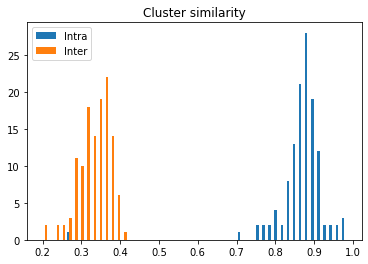

In [39]:
intra_sim, inter_sim = eval_clustering_similarity(y, similarities, verbose=1)

plt.hist([intra_sim, inter_sim], bins=50, label=["Intra", "Inter"])
plt.legend()
plt.title("Cluster similarity")
plt.show()

In [ ]:
similarities = cosine_similarity(embeddings)
for n in [1000]:
    cla = AgglomerativeClustering(n, affinity="cosine", linkage="complete")
    y = cla.fit_predict(embeddings)
    score = silhouette_score(embeddings, y, metric="cosine")
    print(f"{n}: {score}")
    eval_clustering_similarity(y, similarities)

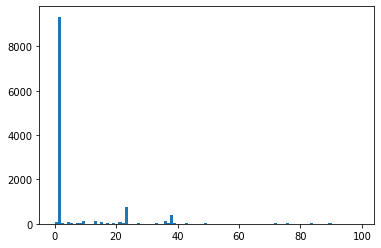

In [17]:
import matplotlib.pyplot as plt
bins, counts = np.unique(y, return_counts=True)
argsort = counts.argsort()[::-1]
plt.bar(range(n), counts[argsort])
plt.yscale("log")
plt.show()

In [33]:
y

array([1, 1, 1, ..., 9, 1, 1])

In [6]:
def find_matches(threshold=None, top_k=None):
    if threshold is None and top_k is None:
        raise ValueError("Specify either threshold or top_k")
    if threshold is not None:
        return [np.where(similarities[i]>=threshold)[0] for i in tqdm(range(len(similarities)))]
    if top_k is not None:
        return [similarities[i].argpartition(-top_k)[-top_k:] for i in tqdm(range(len(similarities)))]

In [7]:
matches = find_matches(threshold=0.7)

100%|██████████| 11986/11986 [00:00<00:00, 63464.46it/s]


In [1]:
index = 2854
print(mssc["norm"].iloc[index])
for i in matches[index]:
    print(f"\t{i}: {similarities[index, i]:.2f} {mssc['norm'].iloc[i]}")

NameError: name 'mssc' is not defined

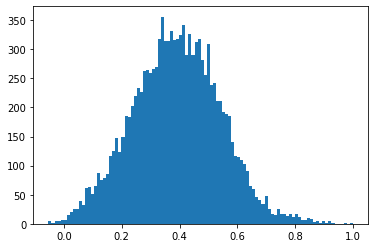

You should never steal someone else's possessions.
	7540: 0.87 It's wrong to steal something that isn't yours.
	8390: 0.88 It's wrong to take other people's things.
	7532: 0.88 It's wrong to steal things from other people.
	9126: 0.88 It's wrong to steal from anyone.
	7700: 0.88 IT is not good to steal from anyone.
	7547: 0.89 It's wrong to steal things from another person.
	9413: 0.89 It's not okay to steal something from someone.
	4415: 0.90 It's wrong to steal from a person's place of business.
	8813: 0.90 You shouldn't take other people's belongings.
	8778: 0.90 You shouldn't take someone else's things.
	2820: 0.90 You shouldn't steal from someone's house.
	6921: 0.91 It's not okay to steal things that aren't yours.
	6692: 0.92 It's unethical and immoral to steal from another person.
	7546: 0.93 It's wrong to steal things that don't belong to you.
	7605: 0.93 You shouldn't steal things that don't belong to you.
	5905: 0.93 It's bad to steal things that don't belong to you.
	7536: 0

In [45]:
index = 31
_ = plt.hist(similarities[index], bins=100)
plt.show()
print(mssc["norm"].iloc[index])
n = 20
most_similar = similarities[index].argsort()[-n:]
for i in range(n):
    k = most_similar[i]
    print(f"\t{k}: {similarities[index, k]:.2f} {mssc['norm'].iloc[k]}")

In [162]:
def find_matches_recursively(threshold):
    matches = []
    for index in tqdm(range(len(mssc))):
        indices = set()
        stack = [index]
        while len(stack) != 0:
            # get next similar norm
            k = stack.pop()
            # add it to indices
            indices.add(k)

            # find all similar to k
            next_similar = set(np.where(similarities[k]>=threshold)[0]) - {k}
            stack += next_similar - indices
        indices -= {index}
        matches.append(indices)
    return matches

100%|██████████| 11986/11986 [00:27<00:00, 435.02it/s] 


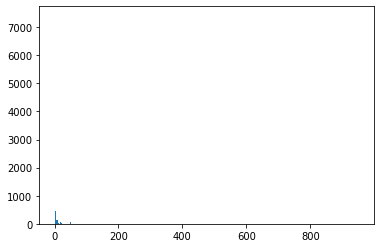

In [163]:
k = [len(x) for x in matches]
_ = plt.hist(k, bins=range(max(k)))
plt.show()

# Clustering with SKlearn
***

In [33]:
from sklearn.cluster import KMeans

# Perform kmean clustering
num_clusters = 500
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings)
clusters = clustering_model.labels_

In [44]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(clusters):
    clustered_sentences[cluster_id].append(mssc["norm"].iloc[sentence_id])

for i, cluster in enumerate(clustered_sentences[:10]):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
["It's hurtful to cost someone their job.", "It's hurtful to have someone fired.", "You shouldn't prevent someone from getting a job.", "It's good to fire someone for being hateful.", "It's bad to try to get someone fired.", 'It is wrong to ruin someones chances at employment.', "It's wrong to get someone fired.", "It's wrong to fire your employees for no reason.", "It's wrong to try to get someone fired.", "It's wrong to strike an employee.", "It's irresponsible to cause someone to lose their job.", "It's rude to make someone lose their job.", "It's rude to plot to get people fired.", "You shouldn't get your friends fired.", "It's wrong to fire someone just because they got injured.", "It's mean to get someone fired from their job.", 'You should fire someone who breaks the rules.', "It's mean to fire someone because they are injured.", 'You should give an employee a warning before firing them.', 'Anyone that is worthy of being fired should be.', "You shouldn't fire someone 

In [35]:
from sklearn import metrics
coefficient = metrics.silhouette_score(embeddings, clustering_model.labels_, metric="euclidean")

In [36]:
metrics.intr

0.057386577

In [40]:
clustering_model.labels_

array([380, 470, 479, ..., 145, 495, 116], dtype=int32)

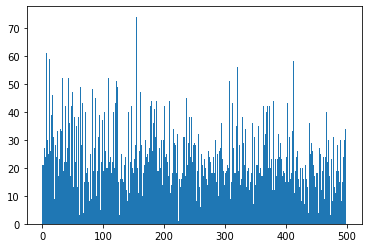

In [39]:
_ = plt.hist(clustering_model.labels_, bins=num_clusters)
plt.show()
